In [1]:
#importing libraries
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
        print(e)

In [3]:
import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 Ti, compute capability 7.5


In [4]:
# Define the SGAM layer
def sgam_layer(inputs):
    _, height, width, filters = inputs.shape.as_list()
    
    x = layers.Reshape((height * width, filters))(inputs)
    x = layers.Dense(units=filters, activation='sigmoid')(x)
    x = layers.Reshape((height, width, filters))(x)
    
    return x

In [5]:
def preprocess_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (192, 192))
        resized_images.append(resized_image)
    # Normalize pixel values
    normalized_images = np.array(resized_images) / 255.0
    return normalized_images

In [6]:
# Create the encoder model
def create_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First set of DSC layers
    x1 = layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x2 = layers.SeparableConv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(inputs)
    x3 = layers.SeparableConv2D(filters=64, kernel_size=(7, 7), padding='same', activation='relu')(inputs)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second set of DSC layers
    x1 = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=128, kernel_size=(7, 7), padding='same', activation='relu')(x)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Third set of DSC layers
    x1 = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Fourth set of DSC layers
    x1 = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Final DSC layer
    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [7]:
create_encoder((192,192,3)).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 192, 192, 64) 283         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 192, 192, 64) 331         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 192, 192, 64) 403         input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
# Create the decoder model
def create_decoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # DSC layer and upsampling
    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # Second set of DSC layers
    x = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # Third set of DSC layers
    x = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # Fourth set of DSC layers
    x = layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # Final DSC layer
    outputs = layers.Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    # Resize the output to the desired shape
   # outputs = tf.image.resize(outputs, (200, 200))

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
create_decoder((12,12,512)).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 12, 512)]     0         
_________________________________________________________________
separable_conv2d_13 (Separab (None, 12, 12, 512)       267264    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 24, 24, 512)       0         
_________________________________________________________________
separable_conv2d_14 (Separab (None, 24, 24, 256)       135936    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 48, 48, 256)       0         
_________________________________________________________________
separable_conv2d_15 (Separab (None, 48, 48, 128)       35200     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 96, 96, 128)       0   

In [10]:
# Create the forgery detection model
def create_forgery_model(input_shape):
    encoder = create_encoder(input_shape)
    decoder = create_decoder(encoder.output_shape[1:])

    inputs = tf.keras.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    return tf.keras.Model(inputs=inputs, outputs=decoded)

In [11]:
import os
import cv2
import numpy as np
from tensorflow import keras

dataset_path = 'D:/VIT/SEM X/Image Forgery/FD3'
train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')

def load_images_from_folder(folder_path, limit=None):
    images = []
    count = 0
    for filename in os.listdir(folder_path):
        if limit is not None and count >= limit:
            break
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            images.append(image)
            count += 1
    return images

# Load training images
train_original_path = os.path.join(train_path, 'img')
train_forged_path = os.path.join(train_path, 'gt')
X_train = load_images_from_folder(train_original_path, limit=10)
y_train = load_images_from_folder(train_forged_path, limit=10)
X_train = preprocess_images(X_train)
y_train = preprocess_images(y_train)

# Load testing images
test_original_path = os.path.join(test_path, 'img')
test_forged_path = os.path.join(test_path, 'gt')
X_test = load_images_from_folder(test_original_path, limit=10)
y_test = load_images_from_folder(test_forged_path, limit=10)
X_test = preprocess_images(X_test)
y_test= preprocess_images(y_test)


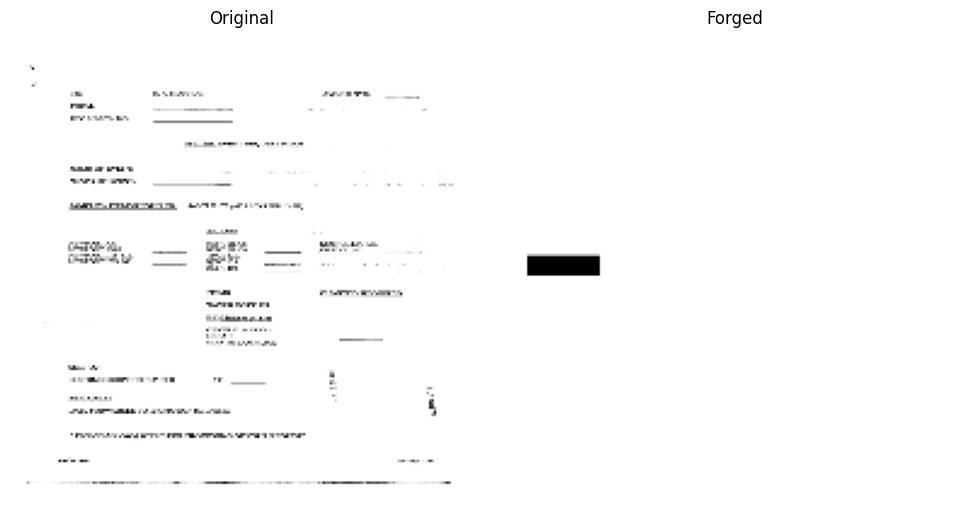

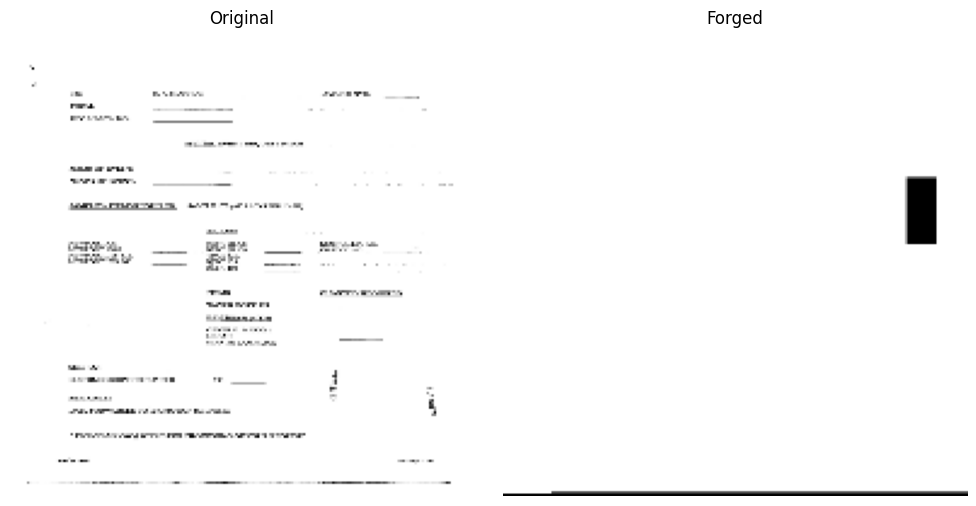

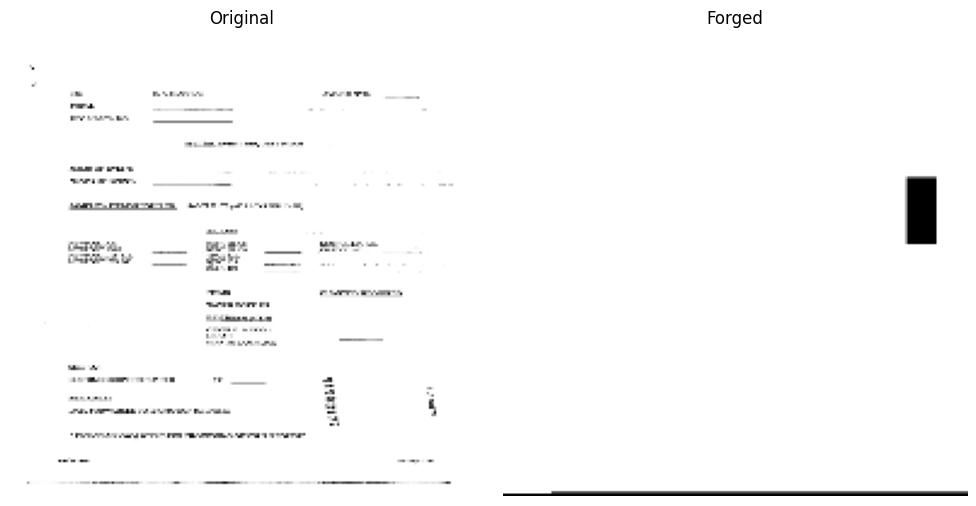

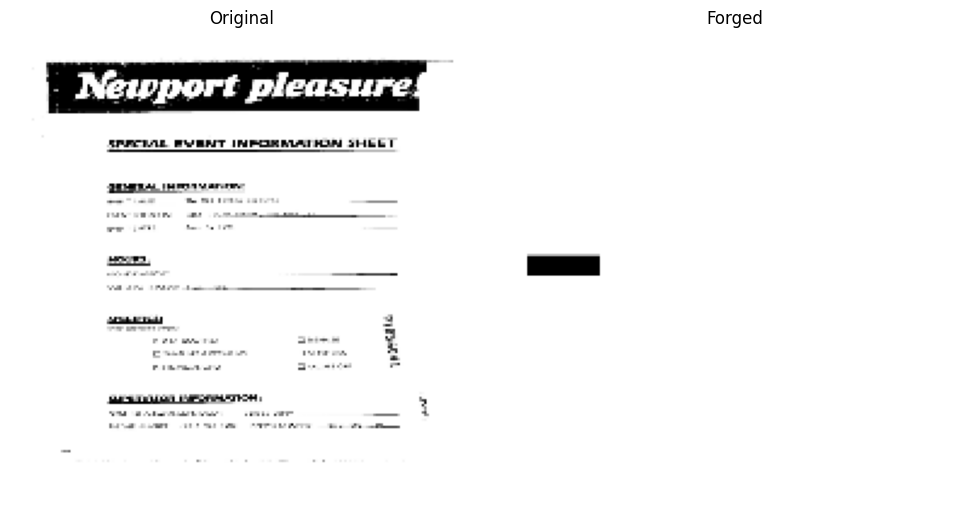

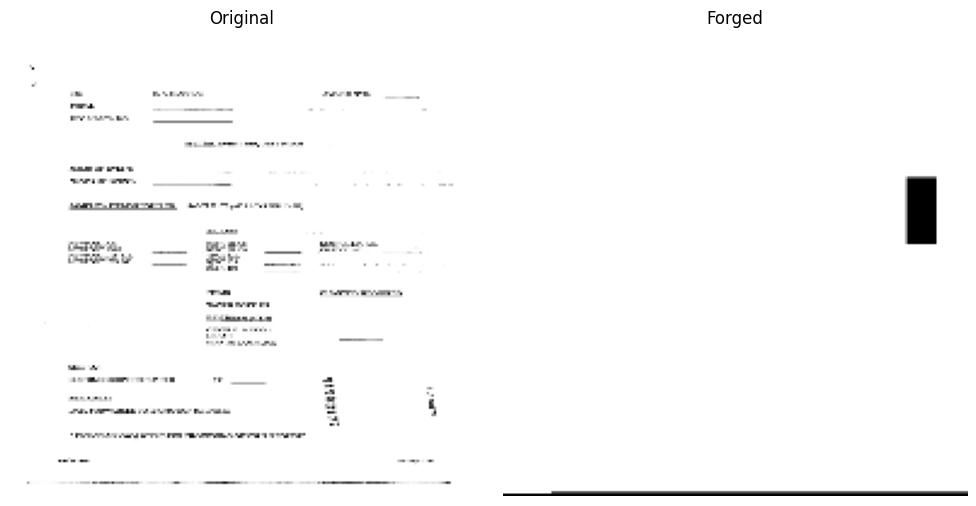

In [12]:
# Print some sample inputs
num_samples = 5
sample_indices = np.random.randint(len(X_train), size=num_samples)

for i in sample_indices:
    if i >= len(X_train):
        continue  # Skip iteration if the index is out of bounds
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(X_train[i])
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    if i >= len(y_test):
        continue  # Skip iteration if the index is out of bounds
    axes[1].imshow(y_test[i])
    axes[1].set_title('Forged')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [13]:
def ssim_loss(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return 1 - ssim

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Create the forgery detection model
model = create_forgery_model(input_shape=(192, 192, 3))
model.compile(optimizer='adam', loss=ssim_loss, metrics=[ssim_metric])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 12, 12, 512)       1473593   
_________________________________________________________________
model_3 (Functional)         (None, 192, 192, 3)       448003    
Total params: 1,921,596
Trainable params: 1,921,596
Non-trainable params: 0
_________________________________________________________________


In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (10, 192, 192, 3)
y_train shape: (10, 192, 192, 3)


In [15]:
from keras.callbacks import ModelCheckpoint

#checkpoint filepath
checkpoint_filepath = 'model_checkpoint.h5'

#checkpoint callback
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, 
                             save_best_only=True, monitor='ssim_metric', mode='max')

In [16]:
from keras.preprocessing.image import ImageDataGenerator

#image data generator
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=4)

In [21]:
# Train the model with the checkpoint callback
model.fit(train_generator, batch_size=8, epochs=100, callbacks=[checkpoint], verbose= True)

Epoch 1/100
3/3 [==============================] - 1s 192ms/step - loss: 0.1242 - ssim_metric: 0.8758
Epoch 2/100
3/3 [==============================] - 1s 254ms/step - loss: 0.1244 - ssim_metric: 0.8756
Epoch 3/100
3/3 [==============================] - 1s 188ms/step - loss: 0.1235 - ssim_metric: 0.8765
Epoch 4/100
3/3 [==============================] - 1s 250ms/step - loss: 0.1229 - ssim_metric: 0.8771
Epoch 5/100
3/3 [==============================] - 1s 253ms/step - loss: 0.1231 - ssim_metric: 0.8769
Epoch 6/100
3/3 [==============================] - 1s 192ms/step - loss: 0.1222 - ssim_metric: 0.8778
Epoch 7/100
3/3 [==============================] - 1s 192ms/step - loss: 0.1220 - ssim_metric: 0.8780
Epoch 8/100
3/3 [==============================] - 1s 250ms/step - loss: 0.1220 - ssim_metric: 0.8780
Epoch 9/100
3/3 [==============================] - 1s 194ms/step - loss: 0.1217 - ssim_metric: 0.8783
Epoch 10/100
3/3 [==============================] - 1s 192ms/step - loss: 0.1207 -

3/3 [==============================] - 1s 196ms/step - loss: 0.1022 - ssim_metric: 0.8978
Epoch 81/100
3/3 [==============================] - 1s 191ms/step - loss: 0.1020 - ssim_metric: 0.8980
Epoch 82/100
3/3 [==============================] - 1s 191ms/step - loss: 0.1024 - ssim_metric: 0.8976
Epoch 83/100
3/3 [==============================] - 1s 253ms/step - loss: 0.1020 - ssim_metric: 0.8980
Epoch 84/100
3/3 [==============================] - 1s 195ms/step - loss: 0.1011 - ssim_metric: 0.8989
Epoch 85/100
3/3 [==============================] - 1s 254ms/step - loss: 0.1012 - ssim_metric: 0.8988
Epoch 86/100
3/3 [==============================] - 1s 252ms/step - loss: 0.1006 - ssim_metric: 0.8994
Epoch 87/100
3/3 [==============================] - 1s 191ms/step - loss: 0.1007 - ssim_metric: 0.8993
Epoch 88/100
3/3 [==============================] - 1s 195ms/step - loss: 0.1004 - ssim_metric: 0.8996
Epoch 89/100
3/3 [==============================] - 1s 253ms/step - loss: 0.1006 - ssi

In [22]:
model.save("image_forgery.h5")

In [23]:
# Create image data generator
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create testing data generator
test_generator = datagen.flow(X_test, y_test, batch_size=16)

# Perform predictions on the testing set
predictions = model.predict(test_generator)

# Compute Intersection over Union (IOU)
iou = tf.keras.metrics.MeanIoU(num_classes=2)
iou.update_state(y_test, predictions)
iou_result = iou.result().numpy()
print("IOU:", iou_result)

# Compute Dice coefficient
dice_coefficient = (2 * iou_result) / (iou_result + 1)
print("Dice Coefficient:", dice_coefficient)

IOU: 0.005963813
Dice Coefficient: 0.01185691367920484
